In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

C:\Users\Harlan Holt\AppData\Roaming\Python\Python39\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#read data
outcomes = pd.read_csv('ab_test_results_aggregated_views_clicks_3.csv')

## Initial data investigation

Initial analysis suggests we have an evenly balanced treatment and control group with outcomes for views and clicks. 

In [3]:
outcomes.head()

,user_id,group,views,clicks
0,1,control,3.0,0.0
1,2,control,2.0,0.0
2,3,control,2.0,0.0
3,4,control,2.0,0.0
4,5,control,5.0,0.0


In [4]:
outcomes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90000 entries, 0 to 89999
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   user_id  90000 non-null  int64  
 1   group    90000 non-null  object 
 2   views    90000 non-null  float64
 3   clicks   90000 non-null  float64
dtypes: float64(2), int64(1), object(1)
memory usage: 2.7+ MB


In [5]:
outcomes['group'].value_counts()

group
control    45000
test       45000
Name: count, dtype: int64

Let's check to make sure there aren't any duplicated user id's by using `set()`

In [6]:
#check for duplicated users
len(outcomes['user_id']) == len(set(outcomes['user_id']))

True

Let's group by control/treatment to get a sense of what our outcomes look like. 

Clicks are highly discretized with most outcomes = 0, and most non-zero outcomes at 1 and declining for 2, 3 and so on. Very few users click more than 5-6 times in either sample, though we do get more in the treatment.

In [7]:
outcomes.groupby(['group', 'clicks'])['user_id'].count()

group    clicks
control  0.0       36138
         1.0        7261
         2.0        1245
         3.0         243
         4.0          71
         5.0          26
         6.0           6
         7.0           6
         8.0           1
         9.0           2
         10.0          1
test     0.0       34145
         1.0        8621
         2.0        1634
         3.0         398
         4.0         121
         5.0          43
         6.0          21
         7.0           9
         8.0           5
         10.0          2
         14.0          1
Name: user_id, dtype: int64

<AxesSubplot:xlabel='clicks', ylabel='Density'>

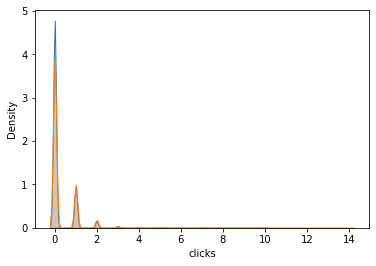

In [8]:
#create masks
control = outcomes['group'] == 'control'
treatment = ~control

sns.kdeplot(outcomes[control]['clicks'], fill = True)
sns.kdeplot(outcomes[treatment]['clicks'], fill = True)

The views outcome appears much more continuous. The distributions lie right on top of each other and have similar means and standard deviations so we'll need a test to see if there's any difference between them.

(Note: I include `ddof = 1` in the options even though it's the default just to keep this calculations straight between this and `np.std()` which defaults `ddof = 0`... annoying.)

<AxesSubplot:xlabel='views', ylabel='Density'>

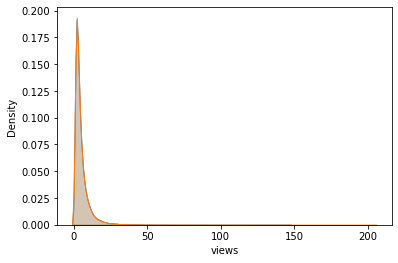

In [9]:
sns.kdeplot(outcomes[control]['views'], fill = True)
sns.kdeplot(outcomes[treatment]['views'], fill = True)

In [10]:
print(f"The mean of views in the control group is {outcomes[control]['views'].mean()}")
print(f"The mean of views in the treatment group is {outcomes[treatment]['views'].mean()}")

print(f"The st deviation of views in the control group is {outcomes[control]['views'].std(ddof = 1)}")
print(f"The st deviation of views in the treatment group is {outcomes[treatment]['views'].std(ddof = 1)}")

The mean of views in the control group is 5.024466666666667
The mean of views in the treatment group is 4.998577777777777
The st deviation of views in the control group is 5.872971146588647
The st deviation of views in the treatment group is 5.926679854713689


In [11]:
outcomes[treatment]['views'].mean() - outcomes[control]['views'].mean()

-0.02588888888888974

## Initial t-test - page views

Let's tackle the easiest problem first. A t-test for the views. We could also concievably do this for clicks, however since clicks is highly discretized, I'd rather treat it as a binomial problem, which we'll tackle next. 

Note that the distribution of `views` is obviously non-normal - probably log-normal as is usual for distributions with many zero-outcomes. In this case our hypothesis tests are compromised since the sampling data clearly violates our normality assumptions. However in this case, there are probably enough observations so that a standard t-test can still apply with a minimal loss in efficiency via the central limit theorem, so for now let's just do that. We can explore ways to correct this next. 

Since the experiment specifies that we're trying to increase the KPIs in the treatment sample, we can use a one-sided test. (Be careful to put your treatment and control in the correct input order in `ttest_ind()`!)

Let's test the hypothesis:

$H_0$: $\mu_{T} = \mu_{C}$

$H_A$: $\mu_{T} > \mu_{C}$

In [12]:
from scipy.stats import ttest_ind, mannwhitneyu

#create dfs for ease of use
df_control = outcomes[control]
df_treatment = outcomes[treatment]

In [13]:
ttest_results = ttest_ind(df_treatment['views'], df_control['views'], alternative = 'greater')
t_stat = ttest_results.statistic
p_val = ttest_results.pvalue

print(f'The t-statistic for this test is {t_stat}')
print(f'The p-value for this test is {p_val}')

print('\n')

if p_val <= 0.05:
    print(f'The mean of the treatment group is statistically higher than the control group. We reject H_0 and accept H_A.')
else:
    print(f'The mean of the treatment group is not statistically higher than the control group. We cannot reject H_0.')

The t-statistic for this test is -0.6582047394076368
The p-value for this test is 0.7447958682785321


The mean of the treatment group is not statistically higher than the control group. We cannot reject H_0.


Cross checking this result against our raw means - we see that the mean in the treatment group is indeed lower than that of the control group accounting for the negative test statistic. Obviously, this treatment did not produce an increase in page views. 

## Non-parametric tests

When dealing with non-normal sampling data, it is sometimes suggested to use non-parametric tests. In this case we can use the Mann-Whitney U-test. Normally however these tests are typically only useful for very small sample sizes ($N <= 30$) and are underpowered compared to t-tests where there is a choice.  

The large value of the U-Stat is reflective of the large sample sizes we have here. Regardless, we get essentially the same p-value as the t-test and so we arrive at the same conclusion as before.

In [14]:
mwu_results = mannwhitneyu(df_treatment['views'], df_control['views'], alternative = 'greater')
u_stat = mwu_results.statistic
p_val_u = mwu_results.pvalue

print(f'The U-statistic for this test is {u_stat}')
print(f'The p-value for this test is {p_val_u}')

print('\n')

if p_val <= 0.05:
    print(f'The mean of the treatment group is statistically higher than the control group. We reject H_0 and accept H_A')
else:
    print(f'The mean of the treatment group is not statistically higher than the control group. We cannot reject H_0.')

The U-statistic for this test is 1009991161.0
The p-value for this test is 0.7423500721091285


The mean of the treatment group is not statistically higher than the control group. We cannot reject H_0.


## Bootstrapping 

Finally, if we're really worried about the non-normality of the sampling distributions, we can always run a bootstrap hypothesis test. The primary advantage of using bootstrapping is that it is agnostic to the sampling distributions you're testing. Thanks to the Central Limit Theorem (CLT) we know that we can take repeated samples from a distribution of any type and the distribution of the means of those samples converges to a normal distribution. 

Here we take repeated samples with replacement, and compare the means between each, and keep a running count of the number of times the mean of the treatment group is larger than the mean of the control group. Let's re-state our hypothesis as:

$H_0$: $Pr(\mu_T > \mu_C) <= 0.5$

$H_A$: $Pr(\mu_T > \mu_C) > 0.5$

Or, the null hypothesis states that the probability that the mean of the treatment group is larger than the mean of the control group is less than or equal to 50\%, and the alternative states that it is greater than 50\%.

In [15]:
subsample_size = 500
samples = 10_000
count = 0
means_treatment = []
means_control = []

for i in range(samples):
    treatment_subsample = df_treatment['views'].sample(n = subsample_size, replace = True)
    control_subsample = df_control['views'].sample(n = subsample_size, replace = True)
    
    mean_treatment = treatment_subsample.mean()
    mean_control = control_subsample.mean()
    
    means_treatment.append(mean_treatment)
    means_control.append(mean_control)
    
    if mean_treatment > mean_control:
        count +=1
        
prob_greater = count/samples

prob_greater

0.4732

47\% of the time we get a sample that produces $\mu^{boot}_T > \mu^{boot}_C$. Obviously, this suggests the mean of the treatment group is not higher than the control group. 

We can plot the distribution of the ratios of the means. As we expected, given the CLT, the normality of the data is restored by taking repeated samples of the data. 

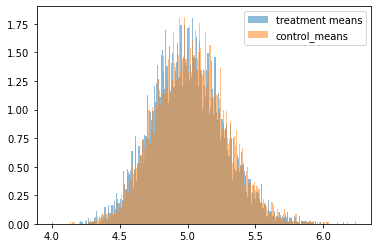

In [16]:
plt.hist(means_treatment, bins = 250, alpha = 0.5, density = True)[2]
plt.hist(means_control, bins = 250, alpha = 0.5, density = True)[2]
plt.legend(['treatment means', 'control_means'])

Lastly, let's take the difference in the means and center the data around zero. This recreates the counterfactual distribution that would obtain *if the null hypothesis was true*.

In [17]:
mean_diff = np.mean(means_treatment) - np.mean(means_control)
mean_diff

-0.024415599999999316

<BarContainer object of 250 artists>

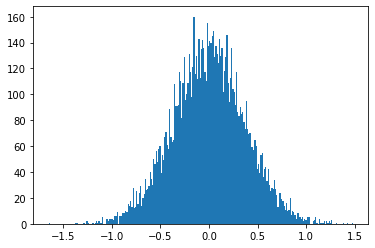

In [18]:
centered_means = np.array(means_treatment)-np.array(means_control)-mean_diff
plt.hist(centered_means, bins = 250)[2]

In [19]:
#check to see that distribution is centered at zero
np.mean(centered_means)

-6.844302902209165e-16

Recall from the origninal data that the raw difference between the treatment and control group page views was $\mu_T - \mu_C = -0.025$. Now from our histogram where the null hypothesis was correct, we just need to calculate the proportion of times we observed that $\mu_T - \mu_C$ was greater than -0.025 to obtain our p-value

In [20]:
#create array of values where centered_means > -0.025
bootstrap_greater = np.where(centered_means > -0.025, 1, 0)

In [21]:
bootstrap_pval = np.mean(bootstrap_greater)
bootstrap_pval

0.5288

Our boostrap p-value is 0.522, which is obviously greater than 0.05. We therefore cannot reject the null hypothesis and again fail to conclude that the variant in the treatment sample increased page views.

## Click throughs (Binarized)

As mentioned, the click through outcomes are highly discretized. We can also do a t-test here - again because the sample size is large enough. However I'm not convinced we get a lot of information given that so few of the outcomes are greater than 1. Instead, let's binarize the outcome (i.e. any clicks = 1, no clicks = 0). 

In [22]:
pd.options.mode.chained_assignment = None

df_treatment['clickthrough_flag'] = np.where(df_treatment['clicks'] > 0, 1, 0)
df_control['clickthrough_flag'] = np.where(df_control['clicks'] > 0, 1, 0)

In [23]:
print(f'Mean clickthrough rate (treatment): {df_treatment.clickthrough_flag.mean()}')
print(f'Mean clickthrough rate (control): {df_control.clickthrough_flag.mean()}')

Mean clickthrough rate (treatment): 0.24122222222222223
Mean clickthrough rate (control): 0.19693333333333332


As we can see there's a big difference (4.5 percentage points) in the binarized clickthrough rate between treatment and control. There's a good chance this is significant.

Since the outcomes are binary, we can treat each observation as a bernoulli trial with probability of a successful click $p$. Since each draw can be thought of as a random sampling from the population of users, the distribution of clicks once again, via the CLT approaches a normal distribution, so a t-test or Z-test is appropriate here. 

In [24]:
ttest_results = ttest_ind(df_treatment['clickthrough_flag'], df_control['clickthrough_flag'], alternative = 'greater')

t_stat = ttest_results.statistic
p_val = ttest_results.pvalue

print(f'The t-statistic for this test is {t_stat}')
print(f'The p-value for this test is {p_val}')

print('\n')

if p_val <= 0.05:
    print(f'The mean of the treatment group is statistically higher than the control group. We reject H_0 and accept H_A.')
else:
    print(f'The mean of the treatment group is not statistically higher than the control group. We cannot reject H_0.')

The t-statistic for this test is 16.084274254146393
The p-value for this test is 1.9825389501689305e-58


The mean of the treatment group is statistically higher than the control group. We reject H_0 and accept H_A.


Here we get a very significantly positive result indicating that the experiment did drive a higher click-through rate. 

## Bootstrapping (again)

Let's bootstrap this too just to see it in action again. 

In [25]:
subsample_size = 500
samples = 10_000
count = 0
means_treatment = []
means_control = []

for i in range(samples):
    treatment_subsample = df_treatment['clickthrough_flag'].sample(n = subsample_size, replace = True)
    control_subsample = df_control['clickthrough_flag'].sample(n = subsample_size, replace = True)
    
    mean_treatment = treatment_subsample.mean()
    mean_control = control_subsample.mean()
    
    means_treatment.append(mean_treatment)
    means_control.append(mean_control)
    
    if mean_treatment > mean_control:
        count +=1
        
prob_greater = count/samples

prob_greater

0.9494

95% of our random samples generated a click-through rate higher than the control group. Once again we can plot the means of the samples against each other:

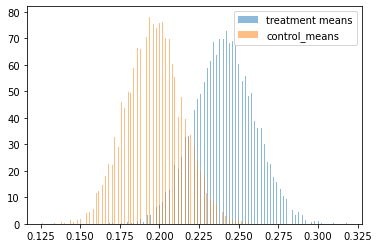

In [26]:
plt.hist(means_treatment, bins = 250, alpha = 0.5, density = True)[2]
plt.hist(means_control, bins = 250, alpha = 0.5, density = True)[2]
plt.legend(['treatment means', 'control_means'])

As we can see the treatment very cleanly separates the distributions in the click-through rate (versus page views where it did not)

Now recall the raw difference in click-through rate is 4.43 percentage points

In [27]:
df_treatment['clickthrough_flag'].mean() - df_control['clickthrough_flag'].mean()

0.044288888888888905

Now we plot the distribution of differences and center around zero as before

0.00010871111111109677


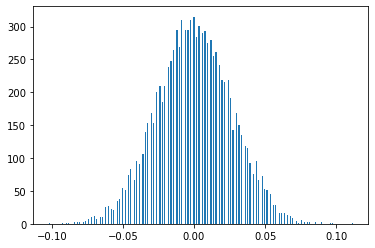

In [28]:
mean_diff = df_treatment['clickthrough_flag'].mean() - df_control['clickthrough_flag'].mean()

ctr_differences = np.array(means_treatment) - np.array(means_control) - mean_diff
plt.hist(ctr_differences, bins = 250)[2]

print(ctr_differences.mean())

Finally, we calculate where the raw differnece lies in the distribution under the null hypothesis to get our p-value as before.

In [29]:
#create array of values where centered_means > -0.025
bootstrap_ctr_greater = np.where(ctr_differences > mean_diff, 1, 0)
np.mean(bootstrap_ctr_greater)

0.0457

So the p-value is 0.04 which is less than 0.05, hence we can reject the null hypothesis, and claim that the treatment worked. 

## Bayesian hypothesis testing



In [31]:
import pymc as pm

def logit(p):
    return np.log(p) - np.log(1 - p)

def inv_logit(p):
    return np.exp(p) / (1 + np.exp(p))

raw_ctr = df_control['clickthrough_rate'].mean()

raw_logit = logit(raw_ctr)

with pm.Model() as model:

    p_T = pm.Normal('p_T', mu = raw_logit, sigma = 0.1)
    p_C = pm.Normal('p_C', mu = raw_logit, sigma = 0.1)
        
    obs_T = pm.Binomial('obs_T', n=df_treatment.shape[0], p=inv_logit(p_A), observed=np.array(df_treatment['clickthrough_flag']))
    obs_B = pm.Binomial('obs_B', n=df_control.shape[0], p=inv_logit(p_B), observed=np.array(df_treatment['clickthrough_flag']))
    
    pm.Deterministic('difference', p_B - p_A)
    
    trace = pm.sample(draws=50000, progressbar=True)
    
    pm.traceplot(trace[1000:])
    
    pm.plot_posterior(trace, var_names=['p_A', 'p_B'], 
                      ref_val=0)
    
    pm.plot_posterior(trace, var_names=['difference'], 
                      ref_val=0)

    

ModuleNotFoundError: No module named 'pymc'

In [31]:
pip install pymc --user

  Using cached pymc-5.12.0-py3-none-any.whl (473 kB)
  Using cached arviz-0.17.1-py3-none-any.whl (1.7 MB)
  Using cached pytensor-2.19.0-cp39-cp39-win_amd64.whl (1.3 MB)
  Using cached typing_extensions-4.12.2-py3-none-any.whl (37 kB)
  Using cached h5netcdf-1.3.0-py3-none-any.whl (43 kB)
  Using cached matplotlib-3.9.1-cp39-cp39-win_amd64.whl (8.0 MB)
  Using cached scipy-1.13.1-cp39-cp39-win_amd64.whl (46.2 MB)
  Using cached numpy-1.26.4-cp39-cp39-win_amd64.whl (15.8 MB)
  Using cached contourpy-1.2.1-cp39-cp39-win_amd64.whl (182 kB)
  Using cached etuples-0.3.9-py3-none-any.whl
  Using cached miniKanren-1.0.3-py3-none-any.whl
  Using cached logical_unification-0.4.6-py3-none-any.whl
  Using cached cons-0.4.6-py3-none-any.whl
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.1
    Uninstalling numpy-1.22.1:
      Successfully uninstalled numpy-1.22.1
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\Harlan Holt\\AppData\\Roaming\\Python\\Python39\\site-packages\\~umpy\\.libs\\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll'
Check the permissions.

